# 基于内容的视频检索系统

系统要求：打开网页后，用户能够上传一个视频截图图片（jpg或者png），点击搜索之后，系统可以返回截图的来源视频，并且从此截图场景在视频中发生的时间点往前10秒开始播放来源视频。用最简单的方法实现基本功能即可，界面设计不作要求。加入索引的视频范围为以下五个，可以每3秒取一帧加入索引，其余两帧跳过；完成索引后索引无需更新，系统可以根据查询图片检索和播放视频即可：

In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

import cv2
import numpy as np
from IPython.display import Image

from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
# load vgg_16 model
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(224, 224,3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    # uncomment the following two lines to remove the top 2 layers for feature extraction
    model.layers.pop()
    model.layers.pop()
    
    # Keras's bug, the modify based on (https://github.com/keras-team/keras/issues/2371)
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []

    return model

In [3]:
# download"vgg16_weights_tf_dim_ordering_tf_kernels.h5"from:(https://github.com/fchollet/deep-learning-models/releases)
model = VGG_16('vgg16_weights.h5')
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

In [4]:
def load_image(imageurl):
    im = cv2.resize(cv2.imread(imageurl),(224,224)).astype(np.float32)
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68
    im = im.transpose((1,0,2))
    im = np.expand_dims(im,axis=0)
    return im

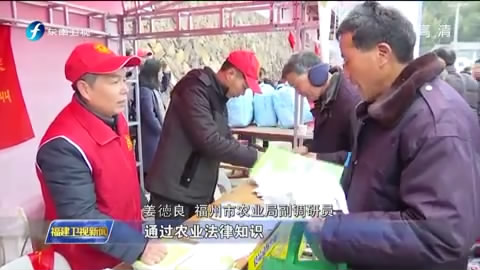

In [5]:
# sample1_1 from vedio 1
Image('sample01.jpg')

In [6]:
def featureOuts(url):
    im = load_image(url)
    out = model.predict(im)
#     print(len(out[0]),out)
    return out[0]

In [7]:
featureOuts('sample01.jpg')

array([ 0.        ,  0.        ,  0.76689571, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [8]:
sample1 = featureOuts('sample01.jpg')

In [9]:
sample1

array([ 0.        ,  0.        ,  0.76689571, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [10]:
import os
from glob import glob
from PIL import Image

def get_batch(image_files):
    data_batch = np.array(
        [load_image(sample_file)[0] for sample_file in image_files]).astype(np.float32)
#     print([sample_file for sample_file in image_files])
#     print(len(data_batch))
    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        print("good!")
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [11]:
data_dir = './data'
show_n_images = 2
labels = glob(os.path.join(data_dir, '*.jpg'))
images = get_batch(labels)

In [12]:
fl=open('labels.txt', 'w')
for i in labels:
    fl.write(i)
    fl.write("\n")
fl.close()

In [13]:
out = model.predict(images)
print(len(out[0]),out)
print(type(out))

4096 [[ 0.          0.92191052  0.         ...,  0.          0.          1.55294847]
 [ 0.11509895  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.91797376]
 ..., 
 [ 0.12773788  0.89609218  0.         ...,  0.          0.          4.60653114]
 [ 0.          0.          4.63690329 ...,  0.          0.          0.        ]
 [ 0.          0.          2.29735088 ...,  0.          0.          1.46318483]]
<class 'numpy.ndarray'>


In [15]:
# save features vector
np.savetxt('new.csv', out, delimiter = ',')

In [14]:
len(out)

315

In [16]:
import nmslib as nl
import numpy
import os

In [17]:
index = nl.init(method='hnsw', space='l2')

index.addDataPointBatch(out)
index.createIndex({'post': 2}, print_progress=True)


# query for the nearest neighbours of the first datapoint
ids, distances = index.knnQuery(out[0], k=10)
print(ids)
print(distances)

[ 0 43 17 18 38 20 29 31 54 24]
[    0.           209.77398682   237.12132263   356.10229492   471.22842407
  1574.46484375  2324.87670898  2349.77148438  2405.52441406  2445.24511719]


In [18]:
ids, distances = index.knnQuery(out[55], k=4)
print(ids)
print(distances)
print(labels[55])

[55 53 52 51]
[    0.          1217.7890625   3882.1640625   3898.03857422]
./data\1_900.jpg


In [19]:
ids, distances = index.knnQuery(sample1, k=4)
print(ids)
print(distances)
labels[46]

[ 46  41  40 294]
[ 1060.5423584   4427.48730469  4546.62304688  4925.07128906]


'./data\\1_540.jpg'

In [20]:
labels[ids[0]]

'./data\\1_540.jpg'

In [21]:
Image(labels[ids[0]])

TypeError: 'module' object is not callable

In [22]:
Image('sample1_1.jpg')

TypeError: 'module' object is not callable

In [23]:
labels[ids[0]]

'./data\\1_540.jpg'

In [24]:
vedio_index = labels[ids[0]][7]
frame_index = labels[ids[0]][9:-4]
print(vedio_index,frame_index)

1 540


In [25]:
# load csv and txt to predict KNN
data = np.loadtxt('new.csv',delimiter=",")
f = open('labels.txt','r')
lines = f.readlines()
f.close()

In [26]:
index_1 = nl.init(method='hnsw', space='l2')

index_1.addDataPointBatch(data)
index_1.createIndex({'post': 2}, print_progress=True)

# query for the nearest neighbours of the first datapoint
ids, distances = index_1.knnQuery(data[0], k=10)
print(ids)
print(distances)

[ 0 43 17 18 38 20 29 31 54 24]
[    0.           209.77398682   237.12132263   356.10229492   471.22842407
  1574.46484375  2324.87670898  2349.77148438  2405.52441406  2445.24511719]


In [33]:
ids, distances = index_1.knnQuery(data[314], k=10)
print(ids)
print(distances)

[314 288 287 289 292 284 297 296 128 291]
[    0.          3664.72924805  3694.91357422  3861.11132812  3888.97607422
  3938.38525391  3993.98852539  4018.43554688  4098.07226562  4214.46044922]


In [27]:
ids, distances = index_1.knnQuery(sample1, k=4)
print(ids)
print(distances)
labels[46]

[ 46  41  40 294]
[ 1060.5423584   4427.48730469  4546.62304688  4925.07128906]


'./data\\1_540.jpg'

In [28]:
vedio_index = lines[ids[0]][7]
frame_index = lines[ids[0]][9:-4]
print(vedio_index,frame_index)

1 540.
